In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib 
matplotlib.rcParams.update({'font.size': 16})

import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp2d

numLifetimes = 13
lifetimes = np.linspace(4,10,numLifetimes) #lifetimes in ns
print(lifetimes)
print(numLifetimes)

[ 4.   4.5  5.   5.5  6.   6.5  7.   7.5  8.   8.5  9.   9.5 10. ]
13


# g2 by autocorrelation

In [2]:
# Define the positions in the autocorrelation where peaks should appear 
delayRange = 200
numPulses = int(2*np.floor(delayRange/12.5)+1)
print(f"numPulses = {numPulses}\n")

pulseInRange = np.floor(delayRange/12.5)*12.5
pulses = np.linspace(-pulseInRange,pulseInRange,numPulses)
print(f"pulses = {pulses}")

numt = 2*delayRange*1000+1 
print(f"numt = {numt}")

# array of time (in ns)
tlist = np.linspace(-delayRange, delayRange, numt) 
print(f"shape of tlist = {tlist.shape}\n")

# number of delay elements
numTau = 2*delayRange*1000+1
print(f"numTau = {numTau}")

# array of delays (in ns)
taulist = np.linspace(-delayRange, delayRange, numTau)
print(f"shape of taulist = {taulist.shape}")

#initialise pulsetrain
pulsetrain_1phot = np.zeros((numt, numLifetimes))
singlepulse = np.zeros((numt, numLifetimes))

# fill pulsetrains and single pulses (one per lifetime)
for i in range(numPulses):
    for j in range(numLifetimes):
        
        if pulses[i] != 0:
            # Calculate the exponential for this pulse
            thisPulse = np.exp(-(tlist - pulses[i])/lifetimes[j])
            thisPulse[thisPulse > 1] = 0
            pulsetrain_1phot[:,j] = pulsetrain_1phot[:,j] + thisPulse
            
        else:
            singlepulse[:,j] = np.exp(-(tlist)/lifetimes[j])
            
singlepulse[singlepulse>1] = 0

numPulses = 33

pulses = [-200.  -187.5 -175.  -162.5 -150.  -137.5 -125.  -112.5 -100.   -87.5
  -75.   -62.5  -50.   -37.5  -25.   -12.5    0.    12.5   25.    37.5
   50.    62.5   75.    87.5  100.   112.5  125.   137.5  150.   162.5
  175.   187.5  200. ]
numt = 400001
shape of tlist = (400001,)

numTau = 400001
shape of taulist = (400001,)


In [4]:
#calculate correlations and g2
autoCorr_1phot = np.zeros((numt, numLifetimes))
singleautocorr = np.zeros((numt, numLifetimes))
g2_1phot = np.zeros((numt, numLifetimes))
for i in range(numLifetimes):
    autoCorr_1phot[:,i] = np.correlate(pulsetrain_1phot[:,i],singlepulse[:,i],"same")
    singleautocorr[:,i] = np.correlate(singlepulse[:,i],singlepulse[:,i],"same")
    
    # Calculate g2(by normalizing to the maximum)
    g2_1phot[:,i] = autoCorr_1phot[:,i]/np.max(autoCorr_1phot[:,i])

In [56]:
#save as CSV files
for i in range(numLifetimes):
    filename = './autocorrG2/g2_1000_1photon_' + str(lifetimes[i]) + 'ns.csv'
    np.savetxt(filename, g2_1phot[:,i], delimiter=",")

# g2 by probabilistic modelling

In [36]:
import scipy.io as sio

#load simulated g2 values (from MATLAB)
for i in range(numLifetimes):
    if  i%2==0:
        filename = './stochModelG2/singlePhoton_tauDecay1_' + str(int(lifetimes[i])) + 'ns.mat'
    else:
        filename = './stochModelG2/singlePhoton_tauDecay1_' + str(lifetimes[i]) + 'ns.mat'
    print(f"{filename}")
    if i==0:
        mat_contents = sio.loadmat(filename)
        #mat_timebinsLoad = mat_contents['bins']
        #mat_timebins = np.zeros(mat_timebinsLoad.shape[1]-1)
        #print(f"{mat_timebins.shape}")
        #for j in range(mat_timebins.shape[0]):
        #    mat_timebins[j] = mat_timebinsLoad[j] +0.25
        mat_timebins = np.linspace(-99.75,99.75,400)
        print(f"{mat_timebins.shape}")
        g2_matlab = np.zeros((mat_timebins.shape[0],numLifetimes ))
        g2_matlab[:,i] = mat_contents['y_hist']
        g2_matlab[:,i] = g2_matlab[:,i]/np.max(g2_matlab[:,i])
    else:
        mat_contents = sio.loadmat(filename)
        g2_matlab[:,i] = mat_contents['y_hist']
        g2_matlab[:,i] = g2_matlab[:,i]/np.max(g2_matlab[:,i])  

./stochModelG2/singlePhoton_tauDecay1_4ns.mat
(400,)
./stochModelG2/singlePhoton_tauDecay1_4.5ns.mat
./stochModelG2/singlePhoton_tauDecay1_5ns.mat
./stochModelG2/singlePhoton_tauDecay1_5.5ns.mat
./stochModelG2/singlePhoton_tauDecay1_6ns.mat
./stochModelG2/singlePhoton_tauDecay1_6.5ns.mat
./stochModelG2/singlePhoton_tauDecay1_7ns.mat
./stochModelG2/singlePhoton_tauDecay1_7.5ns.mat
./stochModelG2/singlePhoton_tauDecay1_8ns.mat
./stochModelG2/singlePhoton_tauDecay1_8.5ns.mat
./stochModelG2/singlePhoton_tauDecay1_9ns.mat
./stochModelG2/singlePhoton_tauDecay1_9.5ns.mat
./stochModelG2/singlePhoton_tauDecay1_10ns.mat


# plot comparison

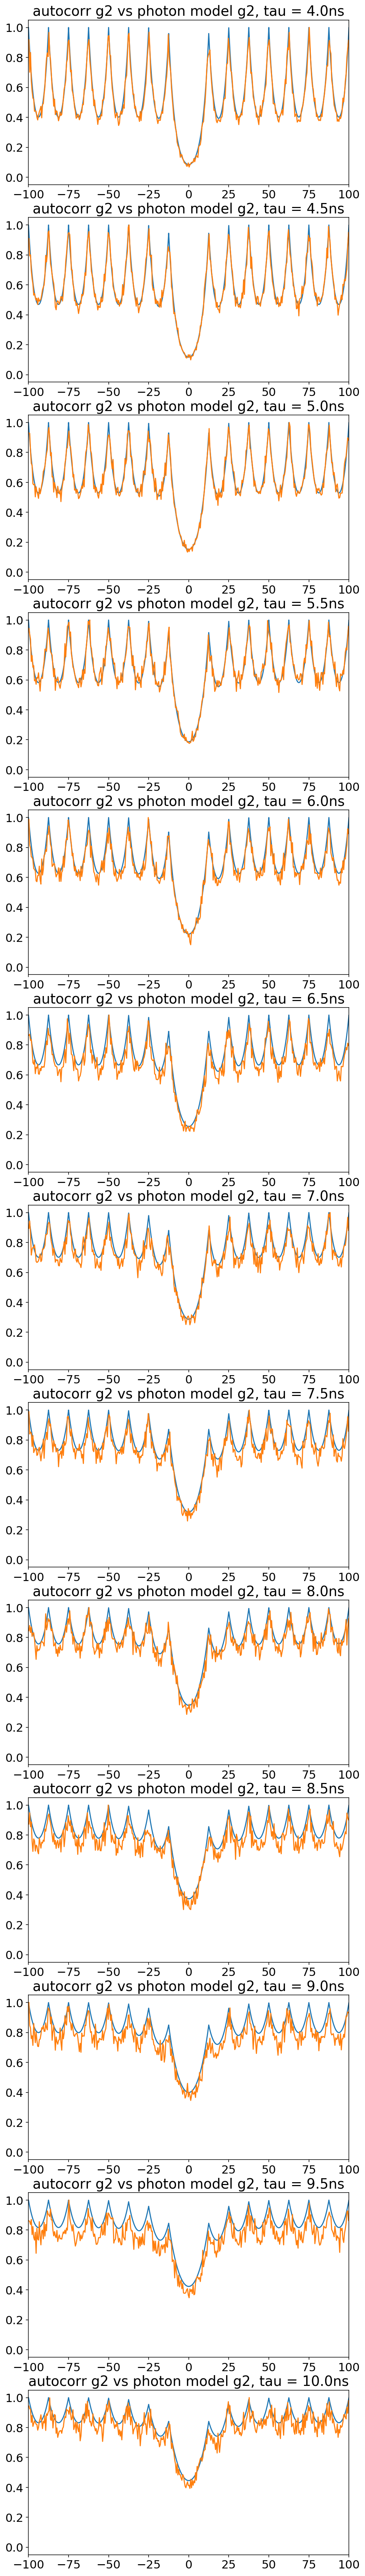

In [54]:
fig0 = plt.figure(figsize=(8,5*numLifetimes))

for i in range(numLifetimes):
    ax = fig0.add_subplot(numLifetimes,1,i+1)
    _ = ax.plot(taulist, g2_1phot[:,i])
    _ = ax.plot(mat_timebins, g2_matlab[:,i])
    _ = ax.set_xlim(-100,100)
    title = 'autocorr g2 vs photon model g2, tau = ' + str(lifetimes[i]) +'ns'
    _ = ax.set_title(title)
